In [2]:
import os
import pandas as pd
import numpy as np

import math

import sklearn

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelBinarizer

from sklearn.manifold import TSNE

In [3]:
np.random.seed(42)

diabetic = pd.read_csv('training/diabetes/diabetic_data_balanced.csv')

# Anonymise
diabetic = diabetic.groupby('patient_nbr', group_keys=False) \
                    .apply(lambda df: df.sample(1))


# Train test split
X, y = diabetic.drop('readmitted', axis=1), diabetic['readmitted']

In [4]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
# PREPROCESSING PIPELINE
diabetic_num_to_cat_features = ['admission_type_id', 'discharge_disposition_id','admission_source_id']

diabetic_cat_to_num_features = ['max_glu_serum', 'A1Cresult']

diabetic_num_features = ['time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

diabetic_drugs = []

diabetic_cat_features = ['race', 'gender', 'change', 'diabetesMed']
diabetic_diag_features = ['diag_1', 'diag_2', 'diag_3']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(diabetic_num_features)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

age_pipeline = Pipeline([
    ('selector', DataFrameSelector(['age'])),
    ('ordinal_encoder', OrdinalEncoder(categories=[['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']])),
    ('std_scaler', StandardScaler()),
])


full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ('age_pipeline', age_pipeline),
])

In [5]:
X_prepared = full_pipeline.fit_transform(X)

In [6]:
X_prepared

array([[-0.56448981, -0.866438  , -0.28758356, ...,  0.59783576,
        -0.88754326, -0.53244174],
       [-0.88254833,  0.11159811, -0.28758356, ..., -0.43146794,
        -1.8733715 , -0.53244174],
       [ 0.07162723,  0.11159811, -0.8567325 , ..., -0.43146794,
        -1.8733715 , -1.72947504],
       ...,
       [-1.20060685,  0.00292743,  1.98901219, ..., -0.43146794,
         0.09828499,  1.26310822],
       [-0.88254833,  0.32893947, -0.8567325 , ..., -0.43146794,
        -0.88754326, -1.13095839],
       [ 0.07162723, -0.16007859, -0.28758356, ...,  2.65644314,
         0.59119911, -0.53244174]])

In [7]:
X_df = pd.DataFrame(X_prepared, columns=diabetic_num_features + ['age'])

In [8]:
X_df

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age
0,-0.564490,-0.866438,-0.287584,-0.166663,-0.18037,-0.163485,0.597836,-0.887543,-0.532442
1,-0.882548,0.111598,-0.287584,-0.537593,-0.18037,-0.163485,-0.431468,-1.873372,-0.532442
2,0.071627,0.111598,-0.856733,-1.279453,-0.18037,-0.163485,-0.431468,-1.873372,-1.729475
3,0.389686,-0.214414,0.281565,-0.290307,-0.18037,-0.163485,0.597836,-2.366286,-0.532442
4,-1.200607,0.002927,1.989012,-0.413950,-0.18037,-0.163485,0.597836,0.098285,-1.130958
...,...,...,...,...,...,...,...,...,...
7939,0.707744,0.002927,-0.287584,0.822483,-0.18037,-0.163485,-0.431468,1.084113,1.263108
7940,-0.882548,0.763622,1.419863,-0.537593,-0.18037,-0.163485,-0.431468,0.591199,0.066075
7941,-1.200607,0.002927,1.989012,-0.290307,-0.18037,-0.163485,-0.431468,0.098285,1.263108
7942,-0.882548,0.328939,-0.856733,-0.413950,-0.18037,-0.163485,-0.431468,-0.887543,-1.130958


# PCA

In [9]:
pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X_prepared)

# how the results are returned
print("μ:", pca.mean_)
k,i = 1,10
print(f"δ[k={k}]:", pca.components_[k])
print(f"λ[k={k},i={i}]:", pca_result[i,k])

μ: [ 4.47219748e-17  1.00177224e-16  2.32554269e-17  1.00177224e-16
 -1.43110319e-17  0.00000000e+00  0.00000000e+00  1.93198931e-16
 -2.28976511e-16]
δ[k=1]: [-0.01039588 -0.067256   -0.19474001 -0.01767866  0.51610773  0.60473694
  0.54393485  0.167418    0.03412446]
λ[k=1,i=10]: -0.6223995217705608


In [11]:
abs(pca.components_)

array([[0.51089487, 0.35870126, 0.37066691, 0.52579245, 0.01179437,
        0.00407309, 0.06375572, 0.39486817, 0.19059598],
       [0.01039588, 0.067256  , 0.19474001, 0.01767866, 0.51610773,
        0.60473694, 0.54393485, 0.167418  , 0.03412446],
       [0.02163186, 0.03480784, 0.38756511, 0.26851249, 0.12350918,
        0.15433341, 0.04305728, 0.43275691, 0.74014121],
       [0.18439862, 0.60997028, 0.46484751, 0.16850179, 0.35191178,
        0.07569393, 0.35407807, 0.03179797, 0.30578339],
       [0.00497012, 0.43927317, 0.21714051, 0.0988249 , 0.6602409 ,
        0.10880583, 0.53928237, 0.04352879, 0.09808685],
       [0.00187249, 0.16225951, 0.0201043 , 0.03637421, 0.37809646,
        0.76883722, 0.48354707, 0.01508087, 0.06187302],
       [0.50888882, 0.06780611, 0.20321433, 0.09626554, 0.10363503,
        0.02249889, 0.00720642, 0.72476924, 0.38637105],
       [0.44172235, 0.5136022 , 0.46502407, 0.19101502, 0.04516521,
        0.01909828, 0.21930899, 0.29955153, 0.3848738 ],


In [20]:
pca_result.shape

(7944, 9)

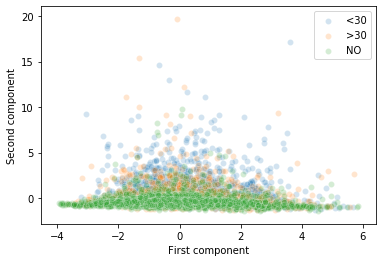

In [47]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cp = sns.color_palette()
%matplotlib inline

p1,p2 = pca_result[:,0], pca_result[:,1]

colors = {'<30': cp[0], '>30': cp[1], 'NO': cp[2]}

for lvl in ['<30', '>30', 'NO']:
    i = (y == lvl)
    sns.scatterplot(p1[i], p2[i], alpha=0.2, label=lvl, palette=colors)
    
plt.xlabel('First component')
plt.ylabel('Second component')
plt.savefig('pca.png', bbox_inches='tight', dpi=600)
plt.show()

# t-SNE

In [52]:
tsne = TSNE(n_components=2, verbose=1)
tsne_result = tsne.fit_transform(X_prepared)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7944 samples in 0.068s...
[t-SNE] Computed neighbors for 7944 samples in 0.947s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7944
[t-SNE] Computed conditional probabilities for sample 2000 / 7944
[t-SNE] Computed conditional probabilities for sample 3000 / 7944
[t-SNE] Computed conditional probabilities for sample 4000 / 7944
[t-SNE] Computed conditional probabilities for sample 5000 / 7944
[t-SNE] Computed conditional probabilities for sample 6000 / 7944
[t-SNE] Computed conditional probabilities for sample 7000 / 7944
[t-SNE] Computed conditional probabilities for sample 7944 / 7944
[t-SNE] Mean sigma: 0.528898
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.735954
[t-SNE] KL divergence after 1000 iterations: 1.854899


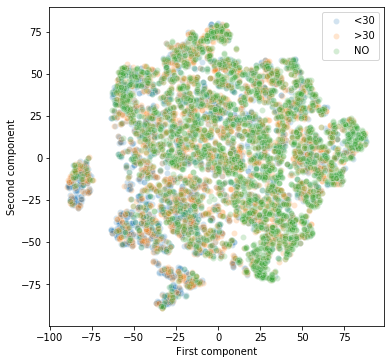

In [55]:
p1,p2 = tsne_result[:,0], tsne_result[:,1]

fig, ax = plt.subplots(figsize=(6,6))
for lvl in ['<30', '>30', 'NO']:
    i = (y == lvl)
    sns.scatterplot(p1[i], p2[i], alpha=0.2, label=lvl, palette=colors)
    
plt.xlabel('First component')
plt.ylabel('Second component')
ax.set_aspect('equal')
plt.savefig('tsne.png', bbox_inches='tight', dpi=600)
plt.show()

In [86]:
tsnes = [sklearn.manifold.TSNE(n_components=2, perplexity=10.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=30.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=50.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=75.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=100.0, verbose=1)]
tsne_results = [tsne.fit_transform(X_prepared) for tsne in tsnes]

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7944 samples in 0.066s...
[t-SNE] Computed neighbors for 7944 samples in 0.675s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7944
[t-SNE] Computed conditional probabilities for sample 2000 / 7944
[t-SNE] Computed conditional probabilities for sample 3000 / 7944
[t-SNE] Computed conditional probabilities for sample 4000 / 7944
[t-SNE] Computed conditional probabilities for sample 5000 / 7944
[t-SNE] Computed conditional probabilities for sample 6000 / 7944
[t-SNE] Computed conditional probabilities for sample 7000 / 7944
[t-SNE] Computed conditional probabilities for sample 7944 / 7944
[t-SNE] Mean sigma: 0.412008
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.707809
[t-SNE] KL divergence after 1000 iterations: 1.791902
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7944 samples in 0.079s...
[t-SNE] Computed neighbors for 7944 samples in 1.002s...
[t-SNE] Computed conditional 

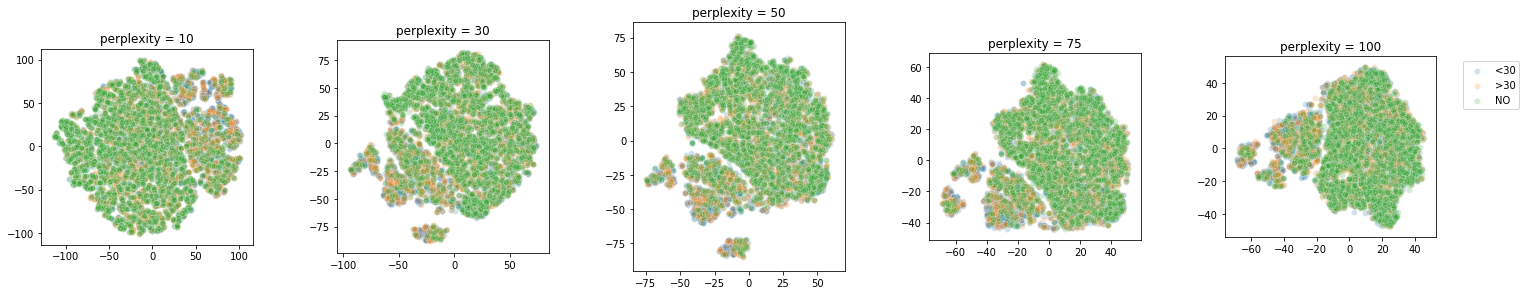

In [96]:
fig = plt.figure(figsize=(25, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.4)
index = 0
plot_index = 1
perplexities = [10, 30, 50, 75, 100]

for i in range(5):
    ax = fig.add_subplot(1, 5, plot_index)
    p1,p2 = tsne_results[index][:,0], tsne_results[index][:,1]

    for lvl in ['<30', '>30', 'NO']:
        i = (y == lvl)
        sns.scatterplot(p1[i], p2[i], alpha=0.2, label=lvl, legend=None)
        ax.set_aspect('equal')
        ax.set_title('perplexity = {}'.format(perplexities[index]))

    index += 1
    plot_index +=1

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.savefig('tsne.png', bbox_inches='tight', dpi=600)
plt.show()

In [90]:
idx=np.random.choice(X_train.shape[0], replace=False, size=2000)

In [91]:
X_reduced = X_train.iloc[idx]
y_reduced = y_train.iloc[idx]

In [92]:
tsne_results_reduced = [tsne.fit_transform(full_pipeline.fit_transform(X_reduced)) for tsne in tsnes]

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.004s...
[t-SNE] Computed neighbors for 2000 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.519158
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.493942
[t-SNE] KL divergence after 1000 iterations: 1.401941
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.005s...
[t-SNE] Computed neighbors for 2000 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.682302
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.071854
[t-SNE] KL divergence after 1000 iterations: 1.436602
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.005s...
[t-SNE] Computed neighbors for 2000 samples in 

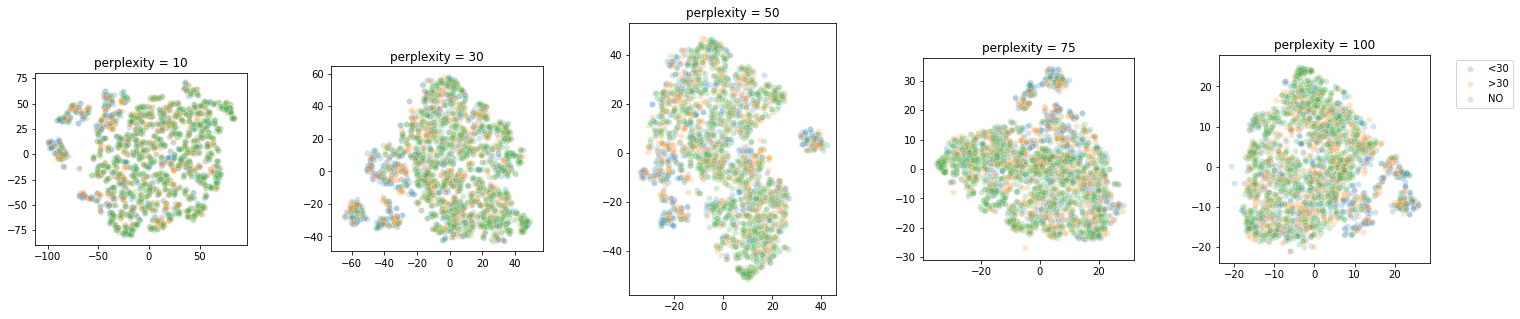

In [99]:
fig = plt.figure(figsize=(25, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.4)
index = 0
plot_index = 1
perplexities = [10, 30, 50, 75, 100]

for i in range(5):
    ax = fig.add_subplot(1, 5, plot_index)
    p1,p2 = tsne_results_reduced[index][:,0], tsne_results_reduced[index][:,1]

    for lvl in ['<30', '>30', 'NO']:
        i = (y_reduced == lvl)
        sns.scatterplot(p1[i], p2[i], alpha=0.2, label=lvl, legend=None)
        ax.set_aspect('equal')
        ax.set_title('perplexity = {}'.format(perplexities[index]))

    index += 1
    plot_index +=1

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))       
plt.show()

In [94]:
pca_result_reduced = pca.fit_transform(full_pipeline.fit_transform(X_reduced))

# how the results are returned
print("μ:", pca.mean_)
k,i = 1,10
print(f"δ[k={k}]:", pca.components_[k])
print(f"λ[k={k},i={i}]:", pca_result_reduced[i,k])

μ: [ 6.75015599e-17 -1.06581410e-17 -3.37507799e-17  9.59232693e-17
 -1.50990331e-17 -2.13162821e-17  6.12843110e-17 -1.24344979e-16
 -6.03961325e-17]
δ[k=2]: [ 0.04362734 -0.00697884  0.42733254  0.2728274   0.00502969  0.12454079
  0.04164868 -0.4566981  -0.7177441 ]
λ[k=2,i=10]: 1.1600446139169576


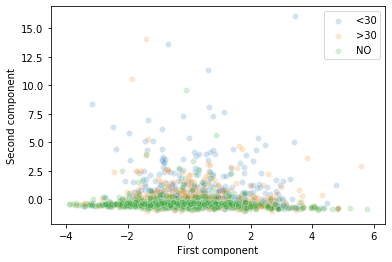

In [95]:
p1,p2 = pca_result_reduced[:,0], pca_result_reduced[:,1]

colors = {'<30': cp[0], '>30': cp[1], 'NO': cp[2]}

for lvl in ['<30', '>30', 'NO']:
    i = (y_reduced == lvl)
    sns.scatterplot(p1[i], p2[i], alpha=0.2, label=lvl, palette=colors)
    
plt.xlabel('First component')
plt.ylabel('Second component')
# plt.savefig('pca.png', bbox_inches='tight', dpi=600)
plt.show()

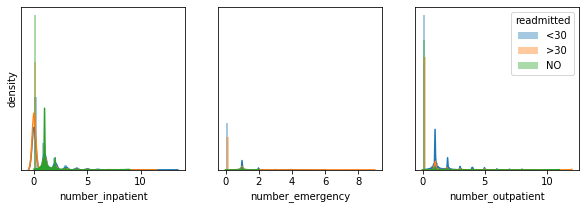

In [16]:
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt

less = diabetic.loc[diabetic['readmitted'] == '<30']
more = diabetic.loc[diabetic['readmitted'] == '>30']
no = diabetic.loc[diabetic['readmitted'] == 'NO']
attrs = [
 'number_inpatient',
 'number_emergency',
 'number_outpatient']
sns.set_palette("tab10")
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i, attr in enumerate(attrs):
    p9 = sns.distplot(less[attr], ax=ax[i])
    p9 = sns.distplot(more[attr], ax=ax[i])
    p9 = sns.distplot(no[attr], ax=ax[i])

    if i==0:
        p9.set(ylabel='density')
    p9.set(xlabel=attr, yticks=[])
plt.legend(title='readmitted', loc='best', labels=['<30', '>30', 'NO'])

In [17]:
p9_fig = p9.get_figure()
p9_fig.savefig("imoutemer.png", bbox_inches='tight', dpi=600)